<!-- NAVIGATION -->
< [Chapter 6. The Haunted DAG & The Causal Terror](06-the-haunted-dag-and-the-causal-terror.html) | [Chapter 8. Conditional Manatees](08-conditional-manatees.html) >

In [0]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, ops, random, vmap
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import ELBO, SVI, Predictive, init_to_value, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

### Code 7.1

In [1]:
sppnames = [
    "afarensis",
    "africanus",
    "habilis",
    "boisei",
    "rudolfensis",
    "ergaster",
    "sapiens",
]
brainvolcc = jnp.array([438, 452, 612, 521, 752, 871, 1350])
masskg = jnp.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

### Code 7.2

In [2]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

### Code 7.3

In [3]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b * mass_std)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1,
    optim.Adam(0.3),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p7_1 = svi.get_params(state)

### Code 7.4

In [4]:
def model(mass_std, brain_std):
    intercept = numpyro.sample("intercept", dist.Normal(0, 10))
    b_mass_std = numpyro.sample("b_mass_std", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2))
    mu = intercept + b_mass_std * mass_std
    numpyro.sample("brain_std", dist.Normal(mu, sigma), obs=brain_std)


m7_1_OLS = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1_OLS,
    optim=optim.Adam(0.01),
    loss=ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p7_1_OLS = svi.get_params(state)
post = m7_1_OLS.sample_posterior(random.PRNGKey(1), p7_1_OLS, (1000,))

### Code 7.5

In [5]:
post = m7_1.sample_posterior(random.PRNGKey(12), p7_1, (1000,))
s = Predictive(m7_1.model, post)(random.PRNGKey(2), d.mass_std.values)
r = jnp.mean(s["brain_std"], 0) - d.brain_std.values
resid_var = jnp.var(r, ddof=1)
outcome_var = jnp.var(d.brain_std.values, ddof=1)
1 - resid_var / outcome_var

DeviceArray(0.49277937, dtype=float32)

### Code 7.6

In [6]:
def R2_is_bad(quap_fit):
    quap, params = quap_fit
    post = quap.sample_posterior(random.PRNGKey(1), params, (1000,))
    s = Predictive(quap.model, post)(random.PRNGKey(2), d.mass_std.values)
    r = jnp.mean(s["brain_std"], 0) - d.brain_std.values
    return 1 - jnp.var(r, ddof=1) / jnp.var(d.brain_std.values, ddof=1)

### Code 7.7

In [7]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([2]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b[0] * mass_std + b[1] * mass_std ** 2)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_2 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 2)})
)
svi = SVI(
    model,
    m7_2,
    optim.Adam(0.3),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p7_2 = svi.get_params(state)

### Code 7.8

In [8]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([3]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + b[0] * mass_std + b[1] * mass_std ** 2 + b[2] * mass_std ** 3
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_3 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 3)})
)
svi = SVI(
    model,
    m7_3,
    optim.Adam(0.01),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p7_3 = svi.get_params(state)


def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([4]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 5)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_4 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 4)})
)
svi = SVI(
    model,
    m7_4,
    optim.Adam(0.01),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p7_4 = svi.get_params(state)


def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([5]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 6)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_5 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 5)})
)
svi = SVI(
    model,
    m7_5,
    optim.Adam(0.01),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p7_5 = svi.get_params(state)

### Code 7.9

In [9]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([6]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 7)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_6 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 6)})
)
svi = SVI(
    model,
    m7_6,
    optim.Adam(0.003),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(5000))
p7_6 = svi.get_params(state)

### Code 7.10

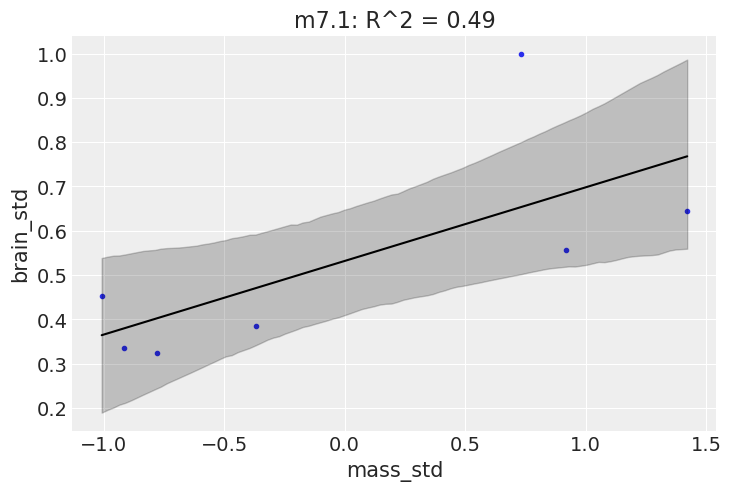

In [10]:
post = m7_1.sample_posterior(random.PRNGKey(1), p7_1, (1000,))
mass_seq = jnp.linspace(d.mass_std.min(), d.mass_std.max(), num=100)
l = Predictive(m7_1.model, post, return_sites=["mu"])(
    random.PRNGKey(2), mass_std=mass_seq
)["mu"]
mu = jnp.mean(l, 0)
ci = jnp.percentile(l, (4.5, 95.5), 0)
az.plot_pair(d[["mass_std", "brain_std"]].to_dict("list"))
plt.plot(mass_seq, mu, "k")
plt.fill_between(mass_seq, ci[0], ci[1], color="k", alpha=0.2)
plt.title("m7.1: R^2 = {:0.2f}".format(R2_is_bad((m7_1, p7_1)).item()))
plt.show()

### Code 7.11

In [11]:
i = 1
d_minus_i = d.drop(i)

### Code 7.12

In [12]:
p = jnp.array([0.3, 0.7])
-jnp.sum(p * jnp.log(p))

DeviceArray(0.61086434, dtype=float32)

### Code 7.13

In [13]:
def lppd_fn(seed, quad, params, num_samples=1000):
    post = quad.sample_posterior(random.PRNGKey(1), params, (int(1e4),))
    logprob = log_likelihood(quad.model, post, d.mass_std.values, d.brain_std.values)
    logprob = logprob["brain_std"]
    return logsumexp(logprob, 0) - jnp.log(logprob.shape[0])


lppd_fn(random.PRNGKey(1), m7_1, p7_1, int(1e4))

DeviceArray([ 0.6190872 ,  0.65552044,  0.54323006,  0.6324444 ,
              0.47280407,  0.439435  , -0.8650408 ], dtype=float32)

### Code 7.14

In [14]:
post = m7_1.sample_posterior(random.PRNGKey(1), p7_1, (int(1e4),))
logprob = log_likelihood(m7_1.model, post, d.mass_std.values, d.brain_std.values)
logprob = logprob["brain_std"]
n = logprob.shape[1]
ns = logprob.shape[0]
f = lambda i: logsumexp(logprob[:, i]) - jnp.log(ns)
lppd = vmap(f)(jnp.arange(n))
lppd

DeviceArray([ 0.6190872 ,  0.65552044,  0.54323006,  0.6324444 ,
              0.47280407,  0.439435  , -0.8650408 ], dtype=float32)

### Code 7.15

In [15]:
[
    jnp.sum(lppd_fn(random.PRNGKey(1), m[0], m[1])).item()
    for m in (
        (m7_1, p7_1),
        (m7_2, p7_2),
        (m7_3, p7_3),
        (m7_4, p7_4),
        (m7_5, p7_5),
        (m7_6, p7_6),
    )
]

[2.4974803924560547,
 2.5913963317871094,
 3.6698169708251953,
 5.34079647064209,
 14.087545394897461,
 19.240093231201172]

### Code 7.16

In [16]:
def model(mm, y, b_sigma):
    a = numpyro.param("a", jnp.array([0.0]))
    Bvec = a
    k = mm.shape[1]
    if k > 1:
        b = numpyro.sample("b", dist.Normal(0, b_sigma).expand([k - 1]))
        Bvec = jnp.concatenate([Bvec, b])
    mu = jnp.matmul(mm, Bvec)
    numpyro.sample("y", dist.Normal(mu, 1), obs=y)


def sim_train_test(i, N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    n_dim = max(k, 3)
    Rho = jnp.identity(n_dim)
    Rho = ops.index_update(Rho, ops.index[1 : len(rho) + 1, 0], jnp.array(rho))
    Rho = ops.index_update(Rho, ops.index[0, 1 : len(rho) + 1], jnp.array(rho))

    X_train = dist.MultivariateNormal(jnp.zeros(n_dim), Rho).sample(
        random.fold_in(random.PRNGKey(0), i), (N,)
    )
    mm_train = jnp.ones((N, 1))
    if k > 1:
        mm_train = jnp.concatenate([mm_train, X_train[:, 1:k]], axis=1)

    if k > 1:
        m = AutoLaplaceApproximation(
            model, init_strategy=init_to_value(values={"b": jnp.zeros(k - 1)})
        )
    else:
        m = lambda mm, y, b_sigma: None
    svi = SVI(
        model, m, optim.Adam(0.3), ELBO(), mm=mm_train, y=X_train[:, 0], b_sigma=b_sigma
    )
    init_state = svi.init(random.fold_in(random.PRNGKey(1), i))
    state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
    params = svi.get_params(state)
    coefs = params["a"]
    if k > 1:
        coefs = jnp.concatenate([coefs, m.median(params)["b"]])

    logprob = dist.Normal(jnp.matmul(mm_train, coefs)).log_prob(X_train[:, 0])
    dev_train = (-2) * jnp.sum(logprob)

    X_test = dist.MultivariateNormal(jnp.zeros(n_dim), Rho).sample(
        random.fold_in(random.PRNGKey(2), i), (N,)
    )
    mm_test = jnp.ones((N, 1))
    if k > 1:
        mm_test = jnp.concatenate([mm_test, X_test[:, 1:k]], axis=1)
    logprob = dist.Normal(jnp.matmul(mm_test, coefs)).log_prob(X_test[:, 0])
    dev_test = (-2) * jnp.sum(logprob)
    return jnp.stack([dev_train, dev_test])


def dev_fn(N, k):
    print(k)
    r = lax.map(lambda i: sim_train_test(i, N, k), jnp.arange((int(1e4))))
    return jnp.concatenate([jnp.mean(r, 0), jnp.std(r, 0)])


N = 20
kseq = range(1, 6)
dev = jnp.stack([dev_fn(N, k) for k in kseq], axis=1)

1
2
3
4
5


### Code 7.17

In [17]:
def dev_fn(N, k):
    print(k)
    r = vmap(lambda i: sim_train_test(i, N, k))(jnp.arange((int(1e4))))
    return jnp.concatenate([jnp.mean(r, 0), jnp.std(r, 0)])

### Code 7.18

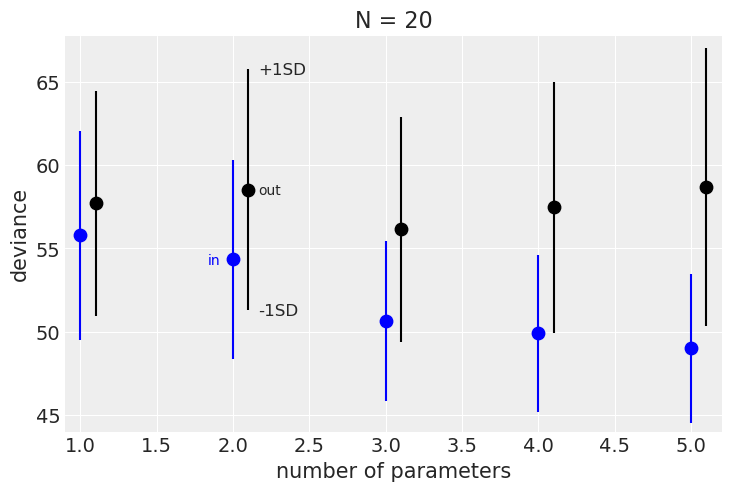

In [18]:
plt.subplot(
    ylim=(jnp.min(dev[0]).item() - 5, jnp.max(dev[0]).item() + 12),
    xlim=(0.9, 5.2),
    xlabel="number of parameters",
    ylabel="deviance",
)
plt.title("N = {}".format(N))
plt.scatter(jnp.arange(1, 6), dev[0], s=80, color="b")
plt.scatter(jnp.arange(1.1, 6), dev[1], s=80, color="k")
pts_int = (dev[0] - dev[2], dev[0] + dev[2])
pts_out = (dev[1] - dev[3], dev[1] + dev[3])
plt.vlines(jnp.arange(1, 6), pts_int[0], pts_int[1], color="b")
plt.vlines(jnp.arange(1.1, 6), pts_out[0], pts_out[1], color="k")
plt.annotate(
    "in", (2, dev[0][1]), xytext=(-25, -5), textcoords="offset pixels", color="b"
)
plt.annotate("out", (2.1, dev[1][1]), xytext=(10, -5), textcoords="offset pixels")
plt.annotate(
    "+1SD",
    (2.1, pts_out[1][1]),
    xytext=(10, -5),
    textcoords="offset pixels",
    fontsize=12,
)
plt.annotate(
    "-1SD",
    (2.1, pts_out[0][1]),
    xytext=(10, -5),
    textcoords="offset pixels",
    fontsize=12,
)
plt.show()

### Code 7.19

In [19]:
cars = pd.read_csv("../data/cars.csv", sep=",")


def model(speed, cars_dist):
    a = numpyro.sample("a", dist.Normal(0, 100))
    b = numpyro.sample("b", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b * speed
    numpyro.sample("dist", dist.Normal(mu, sigma), obs=cars_dist)


m = AutoLaplaceApproximation(model)
svi = SVI(
    model, m, optim.Adam(1), ELBO(), speed=cars.speed.values, cars_dist=cars.dist.values
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
params = svi.get_params(state)
post = m.sample_posterior(random.PRNGKey(94), params, (1000,))

### Code 7.20

In [20]:
n_samples = 1000


def logprob_fn(s):
    mu = post["a"][s] + post["b"][s] * cars.speed.values
    return dist.Normal(mu, post["sigma"][s]).log_prob(cars.dist.values)


logprob = vmap(logprob_fn, out_axes=1)(jnp.arange(n_samples))

### Code 7.21

In [21]:
n_cases = cars.shape[0]
lppd = logsumexp(logprob, 1) - jnp.log(n_samples)

### Code 7.22

In [22]:
pWAIC = jnp.var(logprob, 1)

### Code 7.23

In [23]:
-2 * (jnp.sum(lppd) - jnp.sum(pWAIC))

DeviceArray(427.49634, dtype=float32)

### Code 7.24

In [24]:
waic_vec = -2 * (lppd - pWAIC)
jnp.sqrt(n_cases * jnp.var(waic_vec))

DeviceArray(17.168211, dtype=float32)

### Code 7.25

In [25]:
with numpyro.handlers.seed(rng_seed=71):
    # number of plants
    N = 100

    # simulate initial heights
    h0 = numpyro.sample("h0", dist.Normal(10, 2).expand([N]))

    # assign treatments and simulate fungus and growth
    treatment = jnp.repeat(jnp.arange(2), repeats=N // 2)
    fungus = numpyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4))
    )
    h1 = h0 + numpyro.sample("diff", dist.Normal(5 - 3 * fungus))

    # compose a clean data frame
    d = pd.DataFrame({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})


def model(h0, h1):
    p = numpyro.sample("p", dist.LogNormal(0, 0.25))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_6, optim.Adam(0.1), ELBO(), h0=d.h0.values, h1=d.h1.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p6_6 = svi.get_params(state)


def model(treatment, fungus, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment + bf * fungus
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_7,
    optim.Adam(0.3),
    ELBO(),
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p6_7 = svi.get_params(state)


def model(treatment, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_8 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_8,
    optim.Adam(1),
    ELBO(),
    treatment=d.treatment.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p6_8 = svi.get_params(state)

post = m6_7.sample_posterior(random.PRNGKey(11), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
az.waic(az6_7, scale="deviance")

See http://arxiv.org/abs/1507.04544 for details


Computed from 1000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   336.02    14.65
p_waic            4.08        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

### Code 7.26

In [26]:
post = m6_6.sample_posterior(random.PRNGKey(77), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
post = m6_7.sample_posterior(random.PRNGKey(77), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
post = m6_8.sample_posterior(random.PRNGKey(77), p6_8, (1000,))
logprob = log_likelihood(
    m6_8.model, post, treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values
)
az6_8 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
az.compare({"m6.6": az6_6, "m6.7": az6_7, "m6.8": az6_8}, ic="waic", scale="deviance")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6.7,0,335.903,4.01345,0,0.99977,16.0559,0,True,deviance
m6.8,1,399.758,3.08942,63.8551,0.000229738,12.9573,15.1241,True,deviance
m6.6,2,409.201,1.71209,73.2974,4.42385e-08,14.2718,14.3947,False,deviance


### Code 7.27

In [27]:
post = m6_7.sample_posterior(random.PRNGKey(91), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_7 = az.waic(az6_7, pointwise=True, scale="deviance")
post = m6_8.sample_posterior(random.PRNGKey(91), p6_8, (1000,))
logprob = log_likelihood(
    m6_8.model, post, treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values
)
az6_8 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_8 = az.waic(az6_8, pointwise=True, scale="deviance")
n = waic_m6_7.n_data_points
diff_m6_7_m6_8 = waic_m6_7.waic_i.values - waic_m6_8.waic_i.values
jnp.sqrt(n * jnp.var(diff_m6_7_m6_8))

See http://arxiv.org/abs/1507.04544 for details


DeviceArray(15.060513, dtype=float32)

### Code 7.28

In [28]:
40.0 + jnp.array([-1, 1]) * 10.4 * 2.6

DeviceArray([12.960003, 67.03999 ], dtype=float32)

### Code 7.29

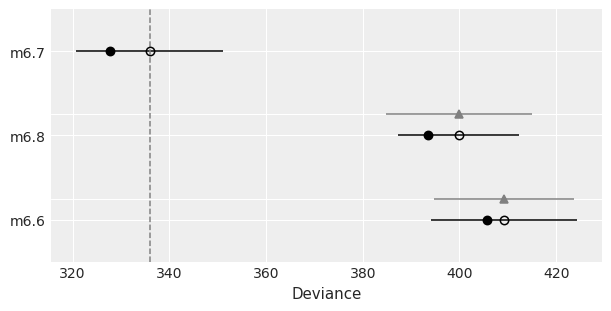

In [29]:
compare = az.compare(
    {"m6.6": az6_6, "m6.7": az6_7, "m6.8": az6_8}, ic="waic", scale="deviance"
)
az.plot_compare(compare)
plt.show()

### Code 7.30

In [30]:
post = m6_6.sample_posterior(random.PRNGKey(92), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_6 = az.waic(az6_6, pointwise=True, scale="deviance")
diff_m6_6_m6_8 = waic_m6_6.waic_i.values - waic_m6_8.waic_i.values
jnp.sqrt(n * jnp.var(diff_m6_6_m6_8))

DeviceArray(7.524173, dtype=float32)

### Code 7.31

In [31]:
post = m6_6.sample_posterior(random.PRNGKey(93), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_6 = az.waic(az6_6, pointwise=True, scale="deviance")
post = m6_7.sample_posterior(random.PRNGKey(93), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_7 = az.waic(az6_7, pointwise=True, scale="deviance")
post = m6_8.sample_posterior(random.PRNGKey(93), p6_8, (1000,))
logprob = log_likelihood(
    m6_8.model, post, treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values
)
az6_8 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_8 = az.waic(az6_8, pointwise=True, scale="deviance")
dSE = lambda waic1, waic2: jnp.sqrt(
    n * jnp.var(waic1.waic_i.values - waic2.waic_i.values)
)
data = {"m6.6": waic_m6_6, "m6.7": waic_m6_7, "m6.8": waic_m6_8}
pd.DataFrame(
    {
        row: {col: dSE(row_val, col_val) for col, col_val in data.items()}
        for row, row_val in data.items()
    }
)

See http://arxiv.org/abs/1507.04544 for details


,m6.6,m6.7,m6.8
m6.6,0.0,14.389981,7.558166
m6.7,14.389981,0.0,15.01256
m6.8,7.558166,15.01256,0.0


### Code 7.32

In [32]:
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), ELBO(), A=d.A.values, D=d.D.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p5_1 = svi.get_params(state)


def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), ELBO(), M=d.M.values, D=d.D.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p5_2 = svi.get_params(state)


def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3, optim.Adam(1), ELBO(), M=d.M.values, A=d.A.values, D=d.D.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p5_3 = svi.get_params(state)

### Code 7.33

In [33]:
post = m5_1.sample_posterior(random.PRNGKey(24071847), p5_1, (1000,))
logprob = log_likelihood(m5_1.model, post, A=d.A.values, D=d.D.values)["D"]
az5_1 = az.from_dict(
    posterior={k: v[None, ...] for k, v in post.items()},
    log_likelihood={"D": logprob[None, ...]},
)
post = m5_2.sample_posterior(random.PRNGKey(24071847), p5_2, (1000,))
logprob = log_likelihood(m5_2.model, post, M=d.M.values, D=d.D.values)["D"]
az5_2 = az.from_dict(
    posterior={k: v[None, ...] for k, v in post.items()},
    log_likelihood={"D": logprob[None, ...]},
)
post = m5_3.sample_posterior(random.PRNGKey(24071847), p5_3, (1000,))
logprob = log_likelihood(m5_3.model, post, A=d.A.values, M=d.M.values, D=d.D.values)[
    "D"
]
az5_3 = az.from_dict(
    posterior={k: v[None, ...] for k, v in post.items()},
    log_likelihood={"D": logprob[None, ...]},
)
az.compare({"m5.1": az5_1, "m5.2": az5_2, "m5.3": az5_3}, ic="waic", scale="deviance")

See http://arxiv.org/abs/1507.04544 for details


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5.1,0,126.516,4.10817,0,0.671151,14.0129,0,True,deviance
m5.3,1,129.008,5.67434,2.49215,0.228679,10.694,1.24717,True,deviance
m5.2,2,139.776,3.28265,13.2601,0.10017,14.9148,9.84543,True,deviance


### Code 7.34

See http://arxiv.org/abs/1507.04544 for details


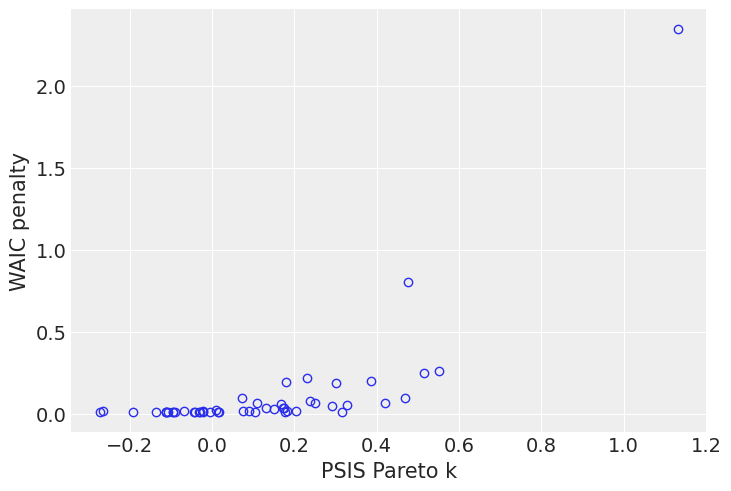

In [34]:
PSIS_m5_3 = az.loo(az5_3, pointwise=True, scale="deviance")
WAIC_m5_3 = az.waic(az5_3, pointwise=True, scale="deviance")
penalty = az5_3.log_likelihood.stack(sample=("chain", "draw")).var(dim="sample")
plt.plot(PSIS_m5_3.pareto_k.values, penalty.D.values, "o", mfc="none")
plt.gca().set(xlabel="PSIS Pareto k", ylabel="WAIC penalty")
plt.show()

### Code 7.35

In [35]:
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("D", dist.StudentT(2, mu, sigma), obs=D)


m5_3t = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_3t, optim.Adam(0.3), ELBO(), M=d.M.values, A=d.A.values, D=d.D.values
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p5_3t = svi.get_params(state)

<!-- NAVIGATION -->
< [Chapter 6. The Haunted DAG & The Causal Terror](06-the-haunted-dag-and-the-causal-terror.html) | [Chapter 8. Conditional Manatees](08-conditional-manatees.html) >